<a href="https://colab.research.google.com/github/rgnemasters/Food_Sales_Prediction_Project/blob/main/Food_Predictions_Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ryan Masters


*   Project Final
*   3/4/2022

**Data Dictionary for this dataset**


|**Variable Name**|	**Description**|
| ----- | ----- |
|Item_Identifier|	Unique product ID|
|Item_Weight|	Weight of product|
|Item_Fat_Content|	Whether the product is low fat or regular|
|Item_Visibility|	The percentage of total display area of all products in a store allocated to the particular product|
|Item_Type|	The category to which the product belongs|
|Item_MRP|	Maximum Retail Price (list price) of the product|
|Outlet_Identifier|	Unique store ID|
|Outlet_Establishment_Year|	The year in which store was established|
|Outlet_Size|	The size of the store in terms of ground area covered|
|Outlet_Location_Type|	The type of area in which the store is located|
|Outlet_Type|	Whether the outlet is a grocery store or some sort of supermarket|
|Item_Outlet_Sales|	Sales of the product in the particular store. This is the target variable to be predicted.|



##Mount Drive, Import Dataset and Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split

Mounted at /content/drive


In [3]:
filename = '/content/drive/MyDrive/Datasets/sales_predictions.csv'
df = pd.read_csv(filename)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


##Manually Clean Data of Null Values and Inconsistencies

In [4]:
#Identify number and location of null values
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [5]:
#determine total number of rows and columns
df.shape

(8523, 12)

In [6]:
# determined data types to check for numerical values stored as strings
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [7]:
#check to find any correlations between null values in Outlet Size category
na_size = df['Outlet_Size'].isna() == True
df.groupby('Outlet_Location_Type')['Outlet_Size'].value_counts(dropna=False)

Outlet_Location_Type  Outlet_Size
Tier 1                Small          1458
                      Medium          930
Tier 2                NaN            1855
                      Small           930
Tier 3                Medium         1863
                      High            932
                      NaN             555
Name: Outlet_Size, dtype: int64

In [8]:
# Based on correlation of Tier 2 locations with Small sized markets, fill NaN's with "Small"
#Based on majority of Tier 3 locations in Medium sized locations, fill these NaN's with "Medium"
outlet_tier1 = df['Outlet_Location_Type'] == 'Tier 1'
outlet_tier2 = df['Outlet_Location_Type'] == 'Tier 2'
outlet_tier3 = df['Outlet_Location_Type'] == 'Tier 3'
df.loc[outlet_tier2 & na_size, 'Outlet_Size'] = 'Small'
df.loc[outlet_tier3 & na_size, 'Outlet_Size'] = 'Medium'
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                     0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [9]:
#Replace inconsistent values to clean up data in 'Item_Fat_Content'
df['Item_Fat_Content'] = df['Item_Fat_Content'].str.replace('LF', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].str.replace('low fat', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].str.replace('reg', 'Regular')
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [10]:
#Reviewing and removing items with a visibility of "0", 
itemVis_null = df['Item_Visibility'] == 0
itemVis_null.sum()

526

In [11]:
#Replacing 0% visibilities with mean
df.loc[itemVis_null, 'Item_Visibility'] = df['Item_Visibility'].median()
df['Item_Visibility'].min()

0.003574698

In [12]:
#Fill NaNs in 'Item_Weight' with mode value.
df['Item_Weight'] = df['Item_Weight'].fillna(df['Item_Weight'].median())
df['Item_Weight'].describe()

count    8523.00000
mean       12.81342
std         4.22724
min         4.55500
25%         9.31000
50%        12.60000
75%        16.00000
max        21.35000
Name: Item_Weight, dtype: float64

#Machine Learning Pre-processing Steps

##Data Validation Split

In [13]:
#Split data by separating 'Item_Outlet_Sales' target and any unique or date columns from training data.
y = df['Item_Outlet_Sales']
X = df.drop(columns = ['Item_Outlet_Sales', 'Outlet_Identifier', 'Item_Identifier', 'Outlet_Establishment_Year'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,16.350,Low Fat,0.029565,Household,256.4646,Medium,Tier 3,Supermarket Type2
7510,15.250,Regular,0.053931,Snack Foods,179.7660,Medium,Tier 3,Supermarket Type2
5828,12.350,Regular,0.158716,Meat,157.2946,Medium,Tier 1,Supermarket Type1
5327,7.975,Low Fat,0.014628,Baking Goods,82.3250,Small,Tier 2,Supermarket Type1
4810,19.350,Low Fat,0.016645,Frozen Foods,120.9098,Small,Tier 2,Supermarket Type1
...,...,...,...,...,...,...,...,...
5734,9.395,Regular,0.286345,Fruits and Vegetables,139.1838,Medium,Tier 3,Grocery Store
5191,15.600,Low Fat,0.117575,Frozen Foods,75.6670,Small,Tier 2,Supermarket Type1
5390,17.600,Low Fat,0.018944,Health and Hygiene,237.3590,Small,Tier 2,Supermarket Type1
860,20.350,Low Fat,0.054363,Snack Foods,117.9466,Small,Tier 2,Supermarket Type1


##Instantiate Selectors and Imputers

In [14]:
#Instantiate selectors and imputers
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
scaler = StandardScaler()

median_imputer = SimpleImputer(strategy='median')
freq_imputer = SimpleImputer(strategy='most_frequent')

##Instantiate Pipeline and Column Transformer

In [15]:
#Instantiate pipeline
num_pipe = make_pipeline(median_imputer, scaler)
cat_pipe = make_pipeline(freq_imputer, ohe)

num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)

preprocessor = make_column_transformer(num_tuple, cat_tuple)
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)
X_train_processed = pd.DataFrame(X_train_processed)

X_train_processed.describe().round(2)

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
count,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,...,6392.00,6392.00,6392.0,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00,6392.00
mean,-0.00,-0.00,0.00,0.65,0.35,0.07,0.03,0.01,0.08,0.08,...,0.11,0.39,0.5,0.27,0.33,0.40,0.12,0.65,0.11,0.11
std,1.00,1.00,1.00,0.48,0.48,0.26,0.16,0.11,0.26,0.27,...,0.31,0.49,0.5,0.45,0.47,0.49,0.33,0.48,0.31,0.32
min,-1.97,-1.36,-1.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,-0.79,-0.75,-0.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,-0.06,-0.31,0.03,1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,1.00,0.00,0.00
75%,0.77,0.52,0.72,1.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,1.0,1.00,1.00,1.00,0.00,1.00,0.00,0.00
max,2.01,5.36,1.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00


#Instantiate and Test Linear Regression Model

In [16]:
#Import and instantiate model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

reg = LinearRegression()

#Fit model on training data and test model's viability
reg.fit(X_train_processed, y_train)

train_preds = reg.predict(X_train_processed)
test_preds = reg.predict(X_test_processed)

train_r2score = r2_score(y_train, train_preds)
test_r2score = r2_score(y_test, test_preds)
train_rmsescore = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmsescore = np.sqrt(mean_squared_error(y_test, test_preds))
print(f'The Regression Model r^2 score for the training data is {train_r2score}')
print(f'The Regression Model r^2 score for the test data is {test_r2score}')
print('\n\n')
print(f'The Regression Model RMSE score for the training data is {train_rmsescore}')
print(f'The Regression Model RMSE score for the test data is {test_rmsescore}')

The Regression Model r^2 score for the training data is 0.5607520948571956
The Regression Model r^2 score for the test data is 0.5656498132657717



The Regression Model RMSE score for the training data is 1140.1467969416103
The Regression Model RMSE score for the test data is 1094.6973555071352


#Instantiate and Test Decision Tree Model

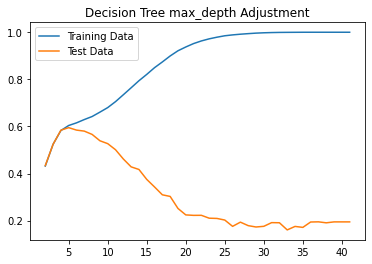

In [17]:
from sklearn.tree import DecisionTreeRegressor

#Plot max_depth to find optimal fit between train and test data
r2_test = []
r2_train = []
depth_range_list = list(range(2, 42))
for depth in depth_range_list:
  dec_tree = DecisionTreeRegressor(random_state=42, max_depth=depth)
  dec_tree.fit(X_train_processed, y_train)
  r2_train_score = dec_tree.score(X_train_processed, y_train)
  r2_test_score = dec_tree.score(X_test_processed, y_test)
  r2_train.append(r2_train_score)
  r2_test.append(r2_test_score)
plt.plot(depth_range_list, r2_train,  label='Training Data')
plt.plot(depth_range_list, r2_test, label = 'Test Data')
plt.title('Decision Tree max_depth Adjustment')
plt.legend()

In [18]:
#Set Decision Tree max_depth to optimal fit
dec_tree = DecisionTreeRegressor(random_state=42, max_depth=5)
dec_tree.fit(X_train_processed, y_train)

dt_trainpreds = dec_tree.predict(X_train_processed)
dt_testpreds = dec_tree.predict(X_test_processed)

dtr2_trainscore = r2_score(y_train, dt_trainpreds)
dtr2_testscore = r2_score(y_test, dt_testpreds)

dtrmse_trainscore = np.sqrt(mean_squared_error(y_train, dt_trainpreds))
dtrmse_testscore =np.sqrt(mean_squared_error(y_test, dt_testpreds))
print(f'The Decision Tree Model r^2 score for the training data is {dtr2_trainscore}')
print(f'The Decision Tree Model r^2 score for the test data is {dtr2_testscore}')
print('\n\n')
print(f'The Decision Tree Model RMSE score for the training data is {dtrmse_trainscore}')
print(f'The Decision Tree Model RMSE score for the test data is {dtrmse_testscore}')

The Decision Tree Model r^2 score for the training data is 0.603933009325518
The Decision Tree Model r^2 score for the test data is 0.5947504400204427



The Decision Tree Model RMSE score for the training data is 1082.65539989706
The Decision Tree Model RMSE score for the test data is 1057.3903403555562


#Instantiate and Test Random Forest Model

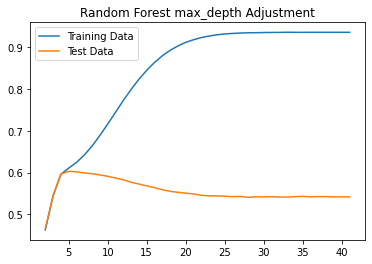

In [19]:
from sklearn.ensemble import RandomForestRegressor

#Test Random Forest Regressor for optimal depth and estimators
r2_test = []
r2_train = []
depth_range_list = list(range(2, 42))
for depth in depth_range_list:
  rf = RandomForestRegressor(random_state=42, max_depth=depth)
  rf.fit(X_train_processed, y_train)
  r2_train_score = rf.score(X_train_processed, y_train)
  r2_test_score = rf.score(X_test_processed, y_test)
  r2_train.append(r2_train_score)
  r2_test.append(r2_test_score)

plt.plot(depth_range_list, r2_train,  label='Training Data')
plt.plot(depth_range_list, r2_test, label = 'Test Data')
plt.title('Random Forest max_depth Adjustment')
plt.legend();

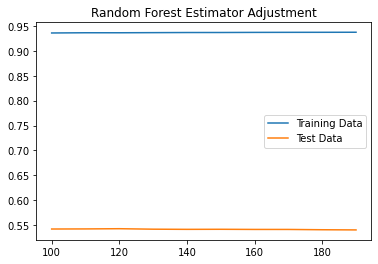

In [20]:
r2est_train = []
r2est_test = []
est_range = list(range(100, 200, 10))
for estimators in est_range:
  rf = RandomForestRegressor(random_state=42, n_estimators=estimators)
  rf.fit(X_train_processed, y_train)
  r2_train_score = rf.score(X_train_processed, y_train)
  r2_test_score = rf.score(X_test_processed, y_test)
  r2est_train.append(r2_train_score)
  r2est_test.append(r2_test_score)
plt.plot(est_range, r2est_train,  label='Training Data');
plt.plot(est_range, r2est_test, label = 'Test Data');
plt.title("Random Forest Estimator Adjustment")
plt.legend()

In [21]:
#Instantiate and test RF model on dataset
rf = RandomForestRegressor(random_state=42, max_depth=5)
rf.fit(X_train_processed, y_train)

rf_trainpreds = rf.predict(X_train_processed)
rf_testpreds = rf.predict(X_test_processed)

rfr2_trainscore = r2_score(y_train, rf_trainpreds)
rfr2_testscore = r2_score(y_test, rf_testpreds)

rfrmse_trainscore = np.sqrt(mean_squared_error(y_train, rf_trainpreds))
rfrmse_testscore =np.sqrt(mean_squared_error(y_test, rf_testpreds))
print(f'The Random Forest Model r^2 score for the training data is {rfr2_trainscore}')
print(f'The Random Forest Model r^2 score for the test data is {rfr2_testscore}')
print('\n\n')
print(f'The Random Forest Model RMSE score for the training data is {rfrmse_trainscore}')
print(f'The Random Forest Model RMSE score for the test data is {rfrmse_testscore}')

The Random Forest Model r^2 score for the training data is 0.6106802012426924
The Random Forest Model r^2 score for the test data is 0.6029880586893722



The Random Forest Model RMSE score for the training data is 1073.3940093541821
The Random Forest Model RMSE score for the test data is 1046.5882328136747


#Plotting Analyses


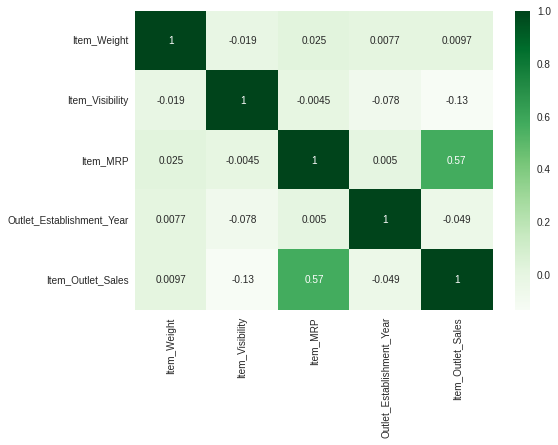

In [22]:
#Use heatmap to review correlations between numeric values
plt.style.use('seaborn')
corr = df.corr()
sns.heatmap(corr, cmap = "Greens", annot = True)

#Review of possible correlation of unit sales and Outlet Location Types. 

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


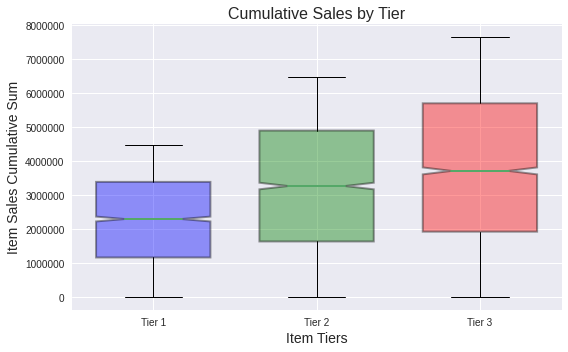

In [23]:
tier1_sales = df.loc[outlet_tier1, 'Item_Outlet_Sales'].cumsum()
tier2_sales = df.loc[outlet_tier2, 'Item_Outlet_Sales'].cumsum()
tier3_sales = df.loc[outlet_tier3, 'Item_Outlet_Sales'].cumsum()
plt.style.use('seaborn')
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (8,5));
boxplots = axes.boxplot([tier1_sales, tier2_sales, tier3_sales], 
                        labels = ["Tier 1", "Tier 2", "Tier 3"], 
                        widths = .7,
                        patch_artist = True,
                        notch = True,
                        medianprops = dict(linestyle='-', linewidth=2),
                        boxprops = dict(linestyle='--', linewidth=2, color='Black', alpha = .4))                      
boxplot1 = boxplots['boxes'][0]
boxplot2 = boxplots['boxes'][1]
boxplot3 = boxplots['boxes'][2]
boxplot1.set_facecolor('blue')
boxplot2.set_facecolor('green')
boxplot3.set_facecolor('red')
plt.title('Cumulative Sales by Tier', fontsize = 16)
plt.ticklabel_format(style = 'plain', axis = 'y')
plt.ylabel('Item Sales Cumulative Sum', fontsize = 14)
plt.xlabel("Item Tiers", fontsize = 14);
plt.tight_layout()
fig.savefig('Cumulative Sales by Tier.png')

This boxplot comparing the cumulative sums of items as they appear in each store tier show a wider IQR in the higher tiers. Furthermore, the median is much higher in Tier 3, suggesting a strong correlation between the store's location and the sales of items.

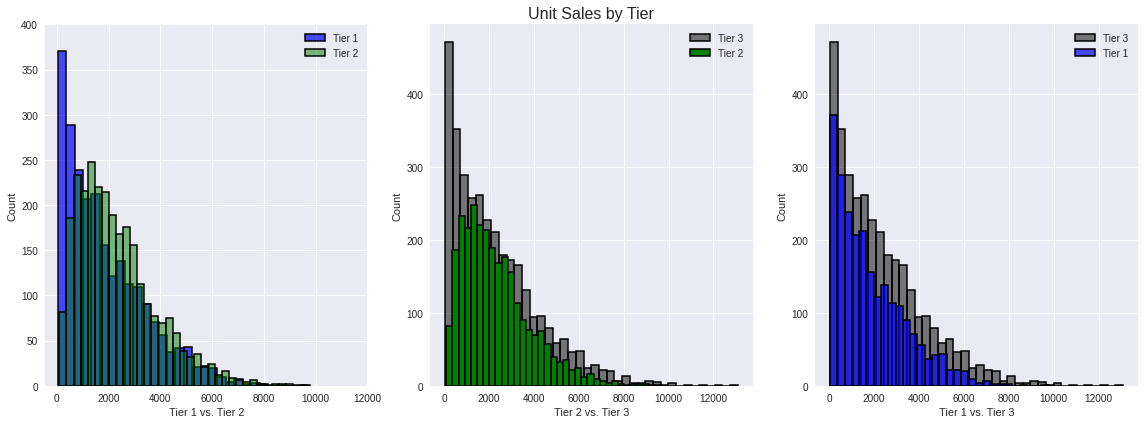

In [24]:
fig, axes = plt.subplots(ncols=3, nrows = 1, figsize = (16, 6));
sns.histplot(data = df[outlet_tier1], x = 'Item_Outlet_Sales', ax = axes[0], alpha = .7,
             label = 'Tier 1', edgecolor = 'black', color = 'blue', lw = 1.5)
sns.histplot(data = df[outlet_tier2], x = 'Item_Outlet_Sales', ax = axes[0], 
             color = 'green', alpha = .5, label = 'Tier 2', edgecolor = 'black', lw = 1.5)
sns.histplot(data = df[outlet_tier3], x = 'Item_Outlet_Sales', ax = axes[1], lw = 1.5, 
             edgecolor = "black", label = "Tier 3", color = 'black', alpha = .5)
sns.histplot(data= df[outlet_tier2], x = 'Item_Outlet_Sales', ax = axes[1], 
             linewidth = 1.5, facecolor = "green", edgecolor="black", label = "Tier 2",
                                                              alpha = .7)
sns.histplot(data = df[outlet_tier3], x = 'Item_Outlet_Sales', ax = axes[2], linewidth = 1.5, 
             edgecolor = "black", label = "Tier 3",
              color = 'black', alpha = .5)
sns.histplot(data = df[outlet_tier1], x = 'Item_Outlet_Sales', ax = axes[2], linewidth = 1.5, color = "blue", 
             edgecolor="black", alpha = .7, label = "Tier 1")

axes[0].legend()
axes[0].set_xlabel('Tier 1 vs. Tier 2')
axes[0].set_ylim(top = 400)
axes[0].set_xlim(right = 12000)
axes[1].set_xlabel('Tier 2 vs. Tier 3')
axes[1].set_title('Unit Sales by Tier', fontsize = 16)
axes[1].legend()
axes[2].set_xlabel('Tier 1 vs. Tier 3')
axes[2].legend();
plt.tight_layout()
fig.savefig('Unit Sales by Tier.png')

Clearly there is a strong connection between number of units (and thus, Item Outlet Sales) that move out of the stores and the location of each store. But this difference seems more meaningful for items located in Tier 3 locations.

Some of this correlation will be attributable to size differences in each class. Tier 3 has a higher concentration of Medium and High sizes. 

Therefore, we'll need to divide sales into per-unit sizes to get a better understanding of what moves sales trends.

#Review of Possible Correlation Between Item Visibility and Sales Types

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
No handles with labels found to put in legend.


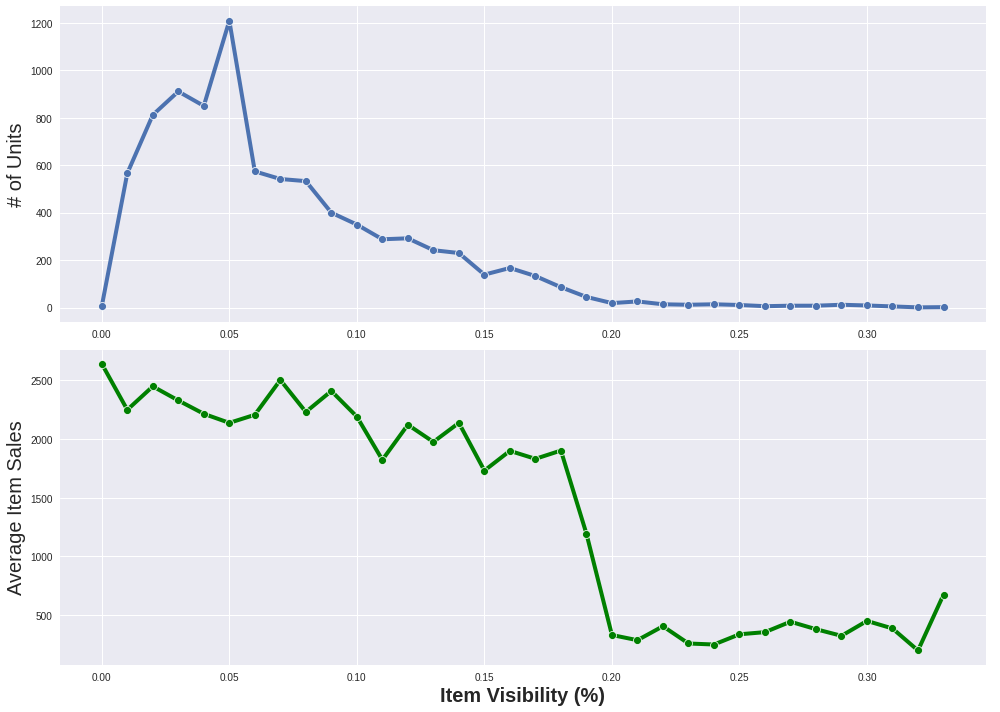

In [25]:
#Produce series's to use for plotting. 
#For lineplot round Item Visibility to nearest hundredth to decrease noise in data.
sales_mean = df.groupby(['Item_Visibility', 'Outlet_Location_Type', 'Item_MRP', 'Outlet_Type'])['Item_Outlet_Sales'].mean().reset_index()
sales_mean = sales_mean.sort_values('Outlet_Location_Type')
itemvis_salescount = sales_mean['Item_Visibility'].round(2).value_counts()

filtered_itemVis = df[['Item_Visibility', 'Item_Outlet_Sales']]
filtered_itemVis.loc[:, 'Item_Visibility'] = filtered_itemVis['Item_Visibility'].round(2)
item_visSales = filtered_itemVis.groupby(['Item_Visibility'])['Item_Outlet_Sales'].mean().round(2)

#Plot data in 3 rows to see overview of Item Visibility effects
fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (14,10))
'''sns.scatterplot(data =  sales_mean, x ='Item_Visibility', y='Item_Outlet_Sales',
                alpha = .6, hue = 'Outlet_Location_Type', ax = axes[0]);'''
sns.lineplot(x = itemvis_salescount.index, y= itemvis_salescount.values, 
             marker = 'o', markersize = 8, lw=4, ax = axes[0])
'''sns.scatterplot(data = sales_mean, x = 'Item_Visibility', y= 'Item_MRP', ax = axes[0], 
                hue = 'Outlet_Location_Type')'''
sns.lineplot(x = item_visSales.index, y = item_visSales.values, ax = axes[1],
             lw = 4, marker = 'o', markersize = 8, color='green');
'''axes[0].set_xlabel('', fontsize = 14)
axes[0].set_ylabel('Average Sales', fontsize = 14)
axes[0].legend(loc=(1, .5))'''
axes[0].set_xlabel('', fontsize = 14)
axes[0].set_ylabel('# of Units', fontsize = 20)
axes[0].legend(loc=(1, .5))
axes[1].set_ylabel('Average Item Sales', fontsize = 20)
axes[1].set_xlabel('Item Visibility (%)', fontsize = 20, fontweight='semibold')
axes[1].ticklabel_format(style='plain')
#fig.suptitle("What affect does an item's visibility have on unit sales and list price?\n\n", fontsize = 20,
 #            fontweight='semibold')
plt.subplots_adjust(hspace = .4, top = .95, bottom = 0)
plt.tight_layout();
fig.savefig('item_vis_image_final2.png')

0.00638274026323306

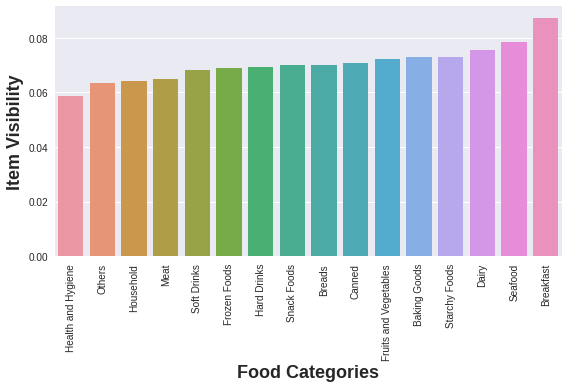

In [26]:
vis_by_type = df.groupby('Item_Type')['Item_Visibility'].mean().sort_values()
sns.barplot(x = vis_by_type.index, y=vis_by_type.values)
plt.xlabel('Food Categories', fontsize = 18, fontweight='semibold')
plt.ylabel('Item Visibility', fontsize=18, fontweight='semibold')
plt.xticks(rotation=90);
plt.tight_layout()
#plt.savefig('vis_by_category1.png')
vis_by_type.values.std()

Mean visibility is 6.6%, and items seem to perform most predictably up to the 15% range, and then there's a big drop-off. 

It seems that Tier 3 does much greater volume, which keeps the visibility rate low for each item. We can see that Tier 1 has items with much higher visibility, but this does not translate to high sales averages.

Lesson: with grocery stores, the more variety the better. Fill shelf-space. 

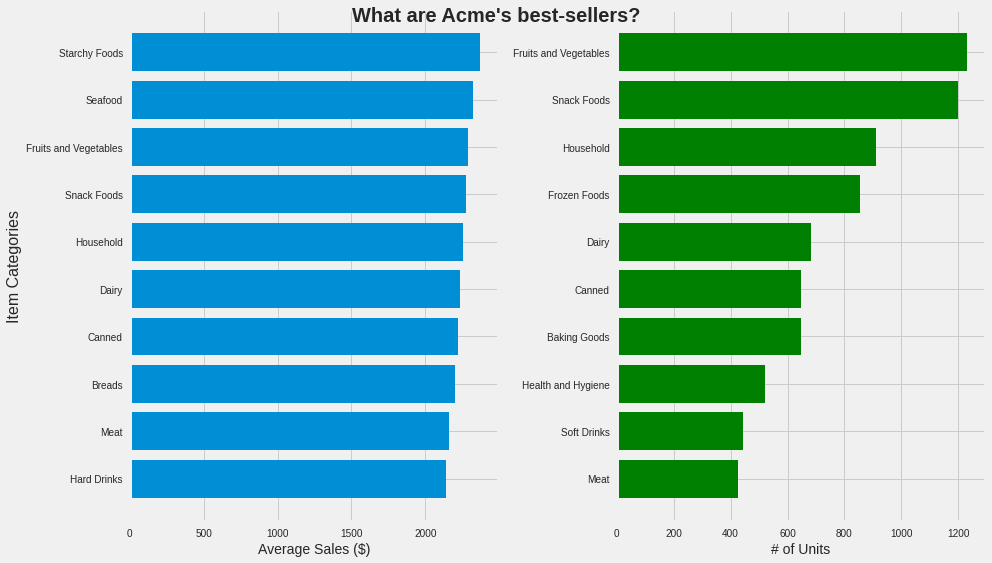

In [27]:
#Calculate top 10 in each category for units sold and total sales average.
item_count = df['Item_Type'].value_counts().sort_values().tail(10)

item_type = df.groupby(['Item_Type'])['Item_Outlet_Sales'].mean().round(2).sort_values().tail(10)                                                                               
    

plt.style.use('fivethirtyeight')
fig, axes = plt.subplots(ncols=2, figsize=(14,8)) 
axes[0].barh(item_type.index, item_type.values, label = 'Item Sales')
axes[1].barh(item_count.index, item_count.values, color = 'green', label = "Units Sold");
axes[0].ticklabel_format(style='plain', axis = 'x')
axes[0].set_xlabel('Average Sales ($)', fontsize = 14)
axes[1].set_xlabel('# of Units', fontsize = 14)
axes[0].set_ylabel('Item Categories', fontsize = 16);
fig.suptitle("What are Acme's best-sellers?", fontsize = 20, fontweight = 'semibold',)
plt.subplots_adjust(wspace = .4)
plt.tight_layout();
#
fig.savefig('best_sellers.png')

In [28]:
display(df.groupby(['Item_Type'])['Item_Outlet_Sales'].mean().round(2).sort_values(ascending=False))
df['Item_Type'].value_counts().sort_values(ascending=False)

Item_Type
Starchy Foods            2374.33
Seafood                  2326.07
Fruits and Vegetables    2289.01
Snack Foods              2277.32
Household                2258.78
Dairy                    2232.54
Canned                   2225.19
Breads                   2204.13
Meat                     2158.98
Hard Drinks              2139.22
Frozen Foods             2132.87
Breakfast                2111.81
Health and Hygiene       2010.00
Soft Drinks              2006.51
Baking Goods             1952.97
Others                   1926.14
Name: Item_Outlet_Sales, dtype: float64

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

Strangely, it looks like Fruits and Vegetables ranks highest by units sold, possibly because most produce is sold in small units. However, it also ranks #3 in average sales.

Seafood seems to be an opportunity in boosting sales, as it comes in #2 behind Starchy Foods while still being low in terms of units sold. 